# barplots of mean relative loss 

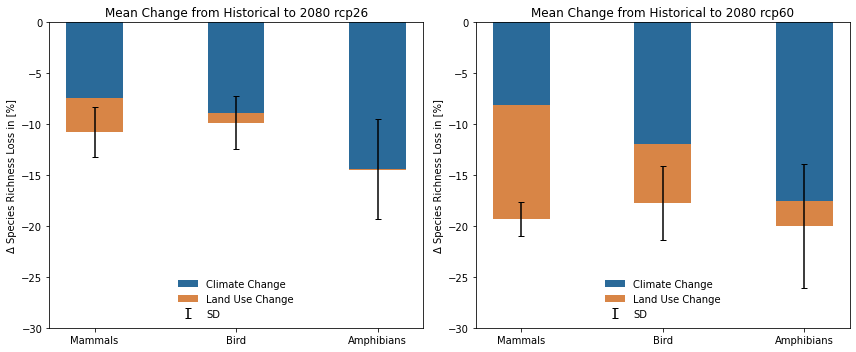

<Figure size 432x288 with 0 Axes>

In [64]:
# relative loss in species richness globally 
import os
import pickle
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Specify the output directory
output_dir = "/storage/scratch/users/ch21o450/data/intermediate_results/"

# List of taxa, SDMs, and GCMs
taxas = ["Mammals", "Bird", "Amphibians"]
sdms = ["GAM", "GBM"]
gcms = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

scenarios = ["rcp26","rcp60"]  # Add rcp26 to the scenarios

time = '65'
time_ind=65
year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

# Load pickled data
mean_newvalue_change = {}
mean_sum_bin_change = {}
mean_land_use_change = {}

for scenario in scenarios:
    mean_newvalue_change[scenario] = {}
    mean_sum_bin_change[scenario] = {}
    mean_land_use_change[scenario] = {}

    for sdm in sdms:
        mean_newvalue_change[scenario][sdm] = {}
        mean_sum_bin_change[scenario][sdm] = {}
        mean_land_use_change[scenario][sdm] = {}

        for gcm in gcms:
            mean_newvalue_change[scenario][sdm][gcm] = {}
            mean_sum_bin_change[scenario][sdm][gcm] = {}
            mean_land_use_change[scenario][sdm][gcm] = {}

            for taxa in taxas:
                # Load pickle files
                newvalue_hist_sum_path = os.path.join(output_dir, f"newvalue_hist_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                newvalue_future_sum_path = os.path.join(output_dir, f"newvalue_future_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                sum_bin_hist_sum_path = os.path.join(output_dir, f"sum_bin_hist_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                sum_bin_future_sum_path = os.path.join(output_dir, f"sum_bin_future_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")

                with open(newvalue_hist_sum_path, "rb") as f:
                    newvalue_hist_sum_taxa = pickle.load(f)

                with open(newvalue_future_sum_path, "rb") as f:
                    newvalue_future_sum_taxa = pickle.load(f)

                with open(sum_bin_hist_sum_path, "rb") as f:
                    sum_bin_hist_sum_taxa = pickle.load(f)

                with open(sum_bin_future_sum_path, "rb") as f:
                    sum_bin_future_sum_taxa = pickle.load(f)

                                # Avoid division by zero
                            # Handle missing values (if necessary)
                # Calculate the difference
                difference = newvalue_future_sum_taxa - newvalue_hist_sum_taxa

                # Identify where there is a loss (future < historical)
                loss_mask = difference < 0

                # Non-zero mask for the historical data to avoid division by zero
                non_zero_mask = newvalue_hist_sum_taxa != 0

                # Calculate relative loss only for loss cases
                # Use xr.where to apply the loss_mask and non_zero_mask
                climate_change = xr.where(loss_mask & non_zero_mask, difference / newvalue_hist_sum_taxa * 100, 0)

                # Repeat similar steps for sum_bin data


                
                                # Calculate the difference
                difference = sum_bin_future_sum_taxa - sum_bin_hist_sum_taxa

                # Identify where there is a loss (future < historical)
                loss_mask = difference < 0

                # Non-zero mask for the historical data to avoid division by zero
                non_zero_mask = sum_bin_hist_sum_taxa != 0

                # Calculate relative loss only for loss cases
                # Use xr.where to apply the loss_mask and non_zero_mask
                climate_land_change = xr.where(loss_mask & non_zero_mask, difference / sum_bin_hist_sum_taxa * 100, 0)

                # Repeat similar steps for sum_bin data


                land_use_change = climate_land_change - climate_change

                climate_land_change_loss = climate_land_change.where(climate_land_change < 0)
                climate_change_loss = climate_change.where((climate_land_change < 0) & (climate_change < 0))


                # Store mean changes in dictionaries
                mean_newvalue_change[scenario][sdm][gcm][taxa] = climate_change_loss
                mean_sum_bin_change[scenario][sdm][gcm][taxa] = climate_land_change_loss
                mean_land_use_change[scenario][sdm][gcm][taxa] = land_use_change

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

color_change = "#2a6a99"
color_land_use_change = "#d88546"

bar_width = 0.4
error_bar_shift = 0.1

x_positions = np.arange(len(taxas))

# Create a variable to store the handles and labels for the legend
handles, labels = [], []

for j, scenario in enumerate(scenarios):
    ax = axes[j]
    scenario_handles, scenario_labels = [], []  # Separate lists for each scenario

    for i, taxa in enumerate(taxas):
        x_shift = x_positions[i]

       # mean_climate_change = np.median([np.mean(mean_newvalue_change[scenario][sdm][gcm][taxa]) for sdm in sdms for gcm in gcms])
       # mean_land_use_change2 = np.median([np.mean(mean_sum_bin_change[scenario][sdm][gcm][taxa] - mean_newvalue_change[scenario][sdm][gcm][taxa]) for sdm in sdms for gcm in gcms])

        #std_dev_climate_change = np.std([np.mean(mean_newvalue_change[scenario][sdm][gcm][taxa]) for sdm in sdms for gcm in gcms])
        
        
        climate_change_data = np.concatenate([mean_newvalue_change[scenario][sdm][gcm][taxa].values.flatten() for sdm in sdms for gcm in gcms])
        land_use_change_data = np.concatenate([mean_sum_bin_change[scenario][sdm][gcm][taxa].values.flatten() for sdm in sdms for gcm in gcms])

        # Calculate the median for the concatenated data
        mean_climate_change = np.nanmean(climate_change_data)
        mean_land_use_change2 = np.nanmean(land_use_change_data) -mean_climate_change
        

        std_dev_climate_change = np.std([np.nanmean(mean_newvalue_change[scenario][sdm][gcm][taxa].values)for sdm in sdms for gcm in gcms])


        if not i:
            handle_climate_change = ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change, label='Climate Change')
            handle_land_use_change = ax.bar(x_shift, mean_land_use_change2, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change, label='Land Use Change')
            handle_error = ax.errorbar(x_shift, mean_climate_change+ mean_land_use_change2, yerr=std_dev_climate_change, fmt='none', capsize=3, color='black', label='SD')

            # Extend the scenario-specific lists
            scenario_handles.extend([handle_climate_change, handle_land_use_change, handle_error])
            scenario_labels.extend(['Climate Change', 'Land Use Change', 'SD'])

        else:
            ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change)
            ax.bar(x_shift, mean_land_use_change2, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change)
            ax.errorbar(x_shift, mean_climate_change+ mean_land_use_change2, yerr=std_dev_climate_change, fmt='none', capsize=3, color='black')

    # Extend the main lists with scenario-specific entries
    handles.extend(scenario_handles)
    labels.extend(scenario_labels)
#for ax in axes:
    ax.set_ylim(top=0, bottom=-30)
    #ax.set_yticks(np.arange(0, -26, -5))
    # Set plot details
    ax.set_xticks(x_positions)
    ax.set_xticklabels(taxas)
    ax.set_ylabel('\u0394 Species Richness Loss in [%]')
    ax.legend(handles=scenario_handles, labels=scenario_labels, frameon=False, loc='lower center')
    ax.set_title(f'Mean Change from Historical to {year_indices[time_ind]} {scenario}')

# Set the final legend outside the loop
#fig.legend(handles=handles, labels=labels, frameon=False, loc='lower center')

plt.tight_layout()
plt.show()
plt.savefig(f"/storage/homefs/ch21o450/scripts/BioScenComb/main_figures/Fig_4_{year_indices[time_ind]}_loss_rel.png")
    #

In [102]:

regionlist = ['West, Central, East & South Africa']



    # ... [code for loading and processing data] ...
for region in regionlist:
    
    oceanic = xr.open_dataset(f"/storage/workspaces/wa_climate/climate_trt/chari/IPBES_subregions/output_{region}_data.nc", decode_times=False)
    oceania_mask_renamed = oceanic.rename({'longitude': 'lon', 'latitude': 'lat'})[f"{region}_data"]
    sumbin_future = xr.open_dataset(f"/storage/scratch/users/ch21o450/data/SR/GAM_65_rcp26_summedprobs_sum_forest.nc", decode_times=False).to_array().isel(variable=0)
    oceania_mask_renamed = oceania_mask_renamed.interp(lat=sumbin_future['lat'], lon=sumbin_future['lon'], method='nearest')


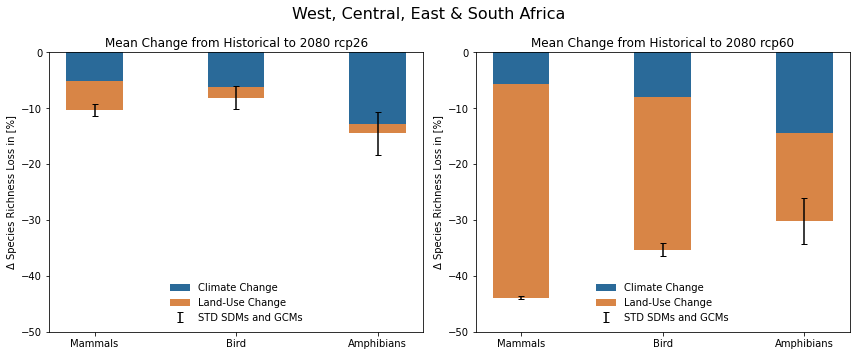

<Figure size 432x288 with 0 Axes>

In [66]:
# relative loss in species richness sub-saharan africa mean
import os
import pickle
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Specify the output directory
output_dir = "/storage/scratch/users/ch21o450/data/intermediate_results/"

# List of taxa, SDMs, and GCMs
taxas = ["Mammals", "Bird", "Amphibians"]
sdms = ["GAM", "GBM"]
gcms = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

scenarios = ["rcp26", "rcp60"]  # Add rcp26 to the scenarios

time = '65'
time_ind=65
year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

# Load pickled data
mean_newvalue_change = {}
mean_sum_bin_change = {}
mean_land_use_change = {}

for scenario in scenarios:
    mean_newvalue_change[scenario] = {}
    mean_sum_bin_change[scenario] = {}
    mean_land_use_change[scenario] = {}

    for sdm in sdms:
        mean_newvalue_change[scenario][sdm] = {}
        mean_sum_bin_change[scenario][sdm] = {}
        mean_land_use_change[scenario][sdm] = {}

        for gcm in gcms:
            mean_newvalue_change[scenario][sdm][gcm] = {}
            mean_sum_bin_change[scenario][sdm][gcm] = {}
            mean_land_use_change[scenario][sdm][gcm] = {}

            for taxa in taxas:
                # Load pickle files
                newvalue_hist_sum_path = os.path.join(output_dir, f"newvalue_hist_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                newvalue_future_sum_path = os.path.join(output_dir, f"newvalue_future_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                sum_bin_hist_sum_path = os.path.join(output_dir, f"sum_bin_hist_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                sum_bin_future_sum_path = os.path.join(output_dir, f"sum_bin_future_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")

                with open(newvalue_hist_sum_path, "rb") as f:
                    newvalue_hist_sum_taxa = pickle.load(f)

                with open(newvalue_future_sum_path, "rb") as f:
                    newvalue_future_sum_taxa = pickle.load(f)

                with open(sum_bin_hist_sum_path, "rb") as f:
                    sum_bin_hist_sum_taxa = pickle.load(f)

                with open(sum_bin_future_sum_path, "rb") as f:
                    sum_bin_future_sum_taxa = pickle.load(f)

                            # Handle missing values (if necessary)
                da1_filled = newvalue_future_sum_taxa.fillna(0)  # Or choose another method to handle NaNs
                da2_filled = newvalue_hist_sum_taxa.fillna(0)  # Or choose another method to handle NaNs

                # Calculate the difference
                difference = da1_filled - da2_filled

                # Identify where there is a loss (da2 < da1)
                loss_mask = difference < 0

                # Calculate relative loss only for loss cases
                relative_loss = difference.where(loss_mask) / da2_filled.where(loss_mask)

                # Handle divisions by zero (if necessary)
                climate_change = relative_loss.fillna(0) * 100  # Replace NaNs from division by zero with 0
                
                
                da1_filled = sum_bin_future_sum_taxa.fillna(0)  # Or choose another method to handle NaNs
                da2_filled = sum_bin_hist_sum_taxa.fillna(0)  # Or choose another method to handle NaNs

                # Calculate the difference
                difference = da1_filled - da2_filled

                # Identify where there is a loss (da2 < da1)
                loss_mask = difference < 0

                # Calculate relative loss only for loss cases
                relative_loss = difference.where(loss_mask) / da2_filled.where(loss_mask)

                # Handle divisions by zero (if necessary)
                climate_land_change = relative_loss.fillna(0) * 100 # Replace NaNs from division by zero with 0


                # Now handle NaN values or negative values as needed
                #climate_land_change_loss = xr.where(climate_land_change < 0, climate_land_change, np.nan)
                #climate_change_loss = xr.where((climate_land_change < 0) & (climate_change < 0), climate_change, np.nan)
                
                climate_land_change_loss = climate_land_change.where(climate_land_change<0).where(oceania_mask_renamed==1)
                climate_change_loss = climate_change.where(climate_change < 0).where(oceania_mask_renamed==1)


                # Store mean changes in dictionaries
                mean_newvalue_change[scenario][sdm][gcm][taxa] = climate_change_loss
                mean_sum_bin_change[scenario][sdm][gcm][taxa] = climate_land_change_loss

                
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

color_change = "#2a6a99"
color_land_use_change = "#d88546"

bar_width = 0.4
error_bar_shift = 0.1

x_positions = np.arange(len(taxas))

# Create a variable to store the handles and labels for the legend
handles, labels = [], []

for j, scenario in enumerate(scenarios):
    ax = axes[j]
    scenario_handles, scenario_labels = [], []  # Separate lists for each scenario

    for i, taxa in enumerate(taxas):
        x_shift = x_positions[i]

        mean_climate_change = np.nanmean([np.nanmean(mean_newvalue_change[scenario][sdm][gcm][taxa]) for sdm in sdms for gcm in gcms])
        mean_land_use_change2 = np.nanmean([np.nanmean(mean_sum_bin_change[scenario][sdm][gcm][taxa] - mean_newvalue_change[scenario][sdm][gcm][taxa]) for sdm in sdms for gcm in gcms])

        std_dev_climate_change = np.std([np.nanmean(mean_newvalue_change[scenario][sdm][gcm][taxa]) for sdm in sdms for gcm in gcms])

        if not i:
            handle_climate_change = ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change, label='Climate Change')
            handle_land_use_change = ax.bar(x_shift, mean_land_use_change2, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change, label='Land-Use Change')
            handle_error = ax.errorbar(x_shift, mean_climate_change+ mean_land_use_change2, yerr=std_dev_climate_change, fmt='none', capsize=3, color='black', label='Climate Change Uncertainty')

            # Extend the scenario-specific lists
            scenario_handles.extend([handle_climate_change, handle_land_use_change, handle_error])
            scenario_labels.extend(['Climate Change', 'Land-Use Change', 'STD SDMs and GCMs'])

        else:
            ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change)
            ax.bar(x_shift, mean_land_use_change2, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change)
            ax.errorbar(x_shift, mean_climate_change+ mean_land_use_change2, yerr=std_dev_climate_change, fmt='none', capsize=3, color='black')

    # Extend the main lists with scenario-specific entries
    handles.extend(scenario_handles)
    labels.extend(scenario_labels)
#for ax in axes:
    ax.set_ylim(top=0, bottom=-50)
    #ax.set_yticks(np.arange(0, -26, -5))
    # Set plot details
    ax.set_xticks(x_positions)
    ax.set_xticklabels(taxas)
    ax.set_ylabel('\u0394 Species Richness Loss in [%]')
    ax.legend(handles=scenario_handles, labels=scenario_labels, frameon=False, loc='lower center')
    ax.set_title(f'Mean Change from Historical to {year_indices[time_ind]} {scenario}')

# Set the final legend outside the loop
#fig.legend(handles=handles, labels=labels, frameon=False, loc='lower center')
fig.suptitle('West, Central, East & South Africa', fontsize=16)
plt.tight_layout()
plt.show()
plt.savefig(f"/storage/homefs/ch21o450/scripts/BioScenComb/main_figures/Fig_4_{year_indices[time_ind]}_loss_rel.png")
    #

# barplots of mean relative gains 

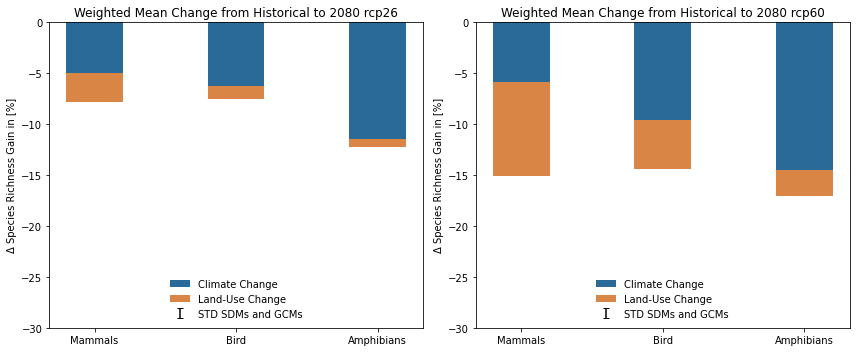

In [149]:
#weighted mean 

import os
import pickle
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
# Constants
R = 6371 * 1e3  # Earth's radius in meters
deg_to_rad = np.pi / 180.0  # Conversion factor from degrees to radians

# Extract lat and lon from your DataArray
lat = newvalue_future_sum_taxa.coords['lat']
lon = newvalue_future_sum_taxa.coords['lon']

# Calculate the area for each latitudinal stripe
# Assuming the latitude and longitude are evenly spaced
lat_edges = np.linspace(90, -90, len(lat) + 1)
lat_rad = lat_edges * deg_to_rad
area_lat = R**2 * np.diff(np.sin(lat_rad))

# The area for each grid cell
cell_area = np.outer(area_lat, np.ones(len(lon)))
# Extract raw coordinate values
lat_values = lat.values
lon_values = lon.values

# Create the xarray DataArray for cell_area using these raw values
cell_area_xr = xr.DataArray(cell_area, coords=[('lat', lat_values), ('lon', lon_values)])



# Specify the output directory
output_dir = "/storage/scratch/users/ch21o450/data/intermediate_results/"

# List of taxa, SDMs, and GCMs
taxas = ["Mammals", "Bird", "Amphibians"]
sdms = ["GAM", "GBM"]
gcms = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

scenarios = ["rcp26", "rcp60"]  # Add rcp26 to the scenarios

time = '65'
time_ind=65
year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

# Load pickled data
mean_newvalue_change = {}
mean_sum_bin_change = {}
mean_land_use_change = {}

weighted_mean_newvalue_change = {}
weighted_mean_sum_bin_change = {}


final_weighted_mean_newvalue_change = {}
final_weighted_mean_sum_bin_change = {}


for scenario in scenarios:
    mean_newvalue_change[scenario] = {}
    mean_sum_bin_change[scenario] = {}
    mean_land_use_change[scenario] = {}
    
    weighted_mean_newvalue_change[scenario] = {}
    weighted_mean_sum_bin_change[scenario] = {}
    
    final_weighted_mean_newvalue_change[scenario] = {}
    final_weighted_mean_sum_bin_change[scenario] = {}
    
    for taxa in taxas: 
        mean_newvalue_change[scenario][taxa]={}
        mean_sum_bin_change[scenario][taxa] = {}
        mean_land_use_change[scenario][taxa] = {}
        
        weighted_mean_newvalue_change[scenario][taxa] = {}
        weighted_mean_sum_bin_change[scenario][taxa] = {}
        
        sdm_data_newvalue = []
        sdm_data_sum_bin = []
        
        for sdm in sdms:
            mean_newvalue_change[scenario][taxa][sdm] = {}
            mean_sum_bin_change[scenario][taxa][sdm] = {}
            mean_land_use_change[scenario][taxa][sdm] = {}
            
            gcm_data_newvalue = []
            gcm_data_sum_bin = []

            for gcm in gcms:
                # Load pickle files
                mean_newvalue_change[scenario][taxa][sdm][gcm] = {}
                mean_sum_bin_change[scenario][taxa][sdm][gcm] = {}
                
                newvalue_hist_sum_path = os.path.join(output_dir, f"newvalue_hist_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                newvalue_future_sum_path = os.path.join(output_dir, f"newvalue_future_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                sum_bin_hist_sum_path = os.path.join(output_dir, f"sum_bin_hist_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                sum_bin_future_sum_path = os.path.join(output_dir, f"sum_bin_future_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")

                with open(newvalue_hist_sum_path, "rb") as f:
                    newvalue_hist_sum_taxa = pickle.load(f)

                with open(newvalue_future_sum_path, "rb") as f:
                    newvalue_future_sum_taxa = pickle.load(f)

                with open(sum_bin_hist_sum_path, "rb") as f:
                    sum_bin_hist_sum_taxa = pickle.load(f)

                with open(sum_bin_future_sum_path, "rb") as f:
                    sum_bin_future_sum_taxa = pickle.load(f)

             # Calculate the difference
                difference = newvalue_future_sum_taxa - newvalue_hist_sum_taxa

                # Identify where there is a loss (future < historical)
                loss_mask = difference < 0

                # Non-zero mask for the historical data to avoid division by zero
                non_zero_mask = newvalue_hist_sum_taxa != 0

                # Calculate relative loss only for loss cases
                # Use xr.where to apply the loss_mask and non_zero_mask
                climate_change = xr.where(loss_mask & non_zero_mask, difference / newvalue_hist_sum_taxa * 100, 0)

                # Repeat similar steps for sum_bin data


                
                                # Calculate the difference
                difference = sum_bin_future_sum_taxa - sum_bin_hist_sum_taxa

                # Identify where there is a loss (future < historical)
                loss_mask = difference < 0

                # Non-zero mask for the historical data to avoid division by zero
                non_zero_mask = sum_bin_hist_sum_taxa != 0

                # Calculate relative loss only for loss cases
                # Use xr.where to apply the loss_mask and non_zero_mask
                climate_land_change = xr.where(loss_mask & non_zero_mask, difference / sum_bin_hist_sum_taxa * 100, 0)



                # Now handle NaN values or negative values as needed
                #climate_land_change_loss = xr.where(climate_land_change < 0, climate_land_change, np.nan)
                #climate_change_loss = xr.where((climate_land_change < 0) & (climate_change < 0), climate_change, np.nan)
                
                climate_land_change_loss = climate_land_change.where(climate_land_change<0)
                climate_change_loss = climate_change.where(climate_change < 0)



                mean_newvalue_change[scenario][taxa][sdm][gcm] = climate_change_loss
                mean_sum_bin_change[scenario][taxa][sdm][gcm] = climate_land_change_loss
                
                gcm_data_newvalue.append(climate_change_loss)
                gcm_data_sum_bin.append(climate_land_change_loss)

            # Convert lists to xarray DataArrays
            gcm_data_newvalue_xr = xr.concat(gcm_data_newvalue, dim='gcm')
            gcm_data_sum_bin_xr = xr.concat(gcm_data_sum_bin, dim='gcm')

            # Calculate weighted mean across GCMs
            weighted_mean_newvalue_change[scenario][taxa][sdm] = gcm_data_newvalue_xr.weighted(cell_area_xr).mean(dim=[ "gcm"])
            weighted_mean_sum_bin_change[scenario][taxa][sdm] = gcm_data_sum_bin_xr.weighted(cell_area_xr).mean(dim=["gcm"])                                                                                                                           

            
            sdm_data_newvalue.append(weighted_mean_newvalue_change[scenario][taxa][sdm])
            sdm_data_sum_bin.append(weighted_mean_sum_bin_change[scenario][taxa][sdm])

        # Convert lists to xarray DataArrays
        sdm_data_newvalue_xr = xr.concat(sdm_data_newvalue, dim='sdm')
        sdm_data_sum_bin_xr = xr.concat(sdm_data_sum_bin, dim='sdm')

        # Calculate the final weighted mean across SDMs
        final_weighted_mean_newvalue_change[scenario][taxa] = sdm_data_newvalue_xr.weighted(cell_area_xr).mean(dim=[ "sdm"])
        final_weighted_mean_sum_bin_change[scenario][taxa] = sdm_data_sum_bin_xr.weighted(cell_area_xr).mean(dim=[ "sdm"])
                # Store GCM-specific data in lists


fig, axes = plt.subplots(1, 2, figsize=(12, 5))


for j, scenario in enumerate(scenarios):
    ax = axes[j]
    scenario_handles, scenario_labels = [], []  # Separate lists for each scenario

    for i, taxa in enumerate(taxas):
        x_shift = x_positions[i]
        
        mean_climate_change = final_weighted_mean_newvalue_change[scenario][taxa].mean().values
        mean_land_use_change = final_weighted_mean_sum_bin_change[scenario][taxa].mean().values - final_weighted_mean_newvalue_change[scenario][taxa].mean().values


        if not i:
            handle_climate_change = ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change, label='Climate Change')
            handle_land_use_change = ax.bar(x_shift, mean_land_use_change, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change, label='Land-Use Change')
  #          handle_error = ax.errorbar(x_shift, mean_climate_change+ mean_land_use_change, yerr=std_dev_climate_change, fmt='none', capsize=3, color='black', label='Climate Change Uncertainty')

            # Extend the scenario-specific lists
            scenario_handles.extend([handle_climate_change, handle_land_use_change, handle_error])
            scenario_labels.extend(['Climate Change', 'Land-Use Change', 'STD SDMs and GCMs'])

        else:
            ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change)
            ax.bar(x_shift, mean_land_use_change, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change)
       #     ax.errorbar(x_shift, mean_climate_change+ mean_land_use_change, yerr=std_dev_climate_change, fmt='none', capsize=3, color='black')

    # Extend the main lists with scenario-specific entries
    handles.extend(scenario_handles)
    labels.extend(scenario_labels)
#for ax in axes:

    # Set plot details
    ax.set_ylim(top=0, bottom=-30)
    ax.set_xticks(x_positions)
    ax.set_xticklabels(taxas)
    ax.set_ylabel('\u0394 Species Richness Gain in [%]')
    ax.legend(handles=scenario_handles, labels=scenario_labels, frameon=False, loc='lower center')
    ax.set_title(f'Weighted Mean Change from Historical to {year_indices[time_ind]} {scenario}')

# Set the final legend outside the loop
#fig.legend(handles=handles, labels=labels, frameon=False, loc='lower center')

plt.tight_layout()
plt.show()


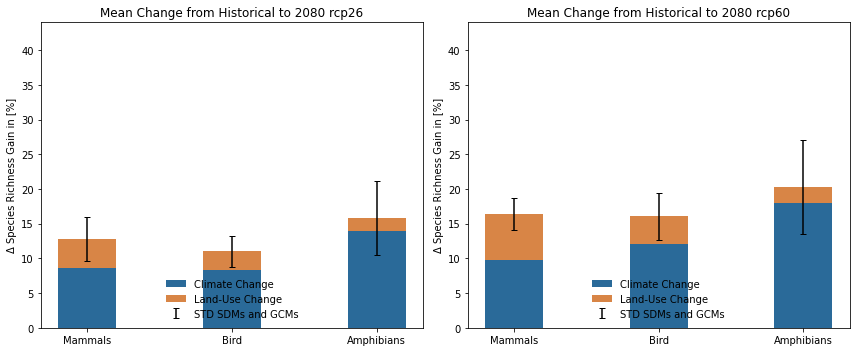

In [36]:
# relative loss in species richness globally 
import os
import pickle
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt


# Specify the output directory
output_dir = "/storage/scratch/users/ch21o450/data/intermediate_results/"

# List of taxa, SDMs, and GCMs
taxas = ["Mammals", "Bird", "Amphibians"]
sdms = ["GAM", "GBM"]
gcms = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

scenarios = ["rcp26", "rcp60"]  # Add rcp26 to the scenarios

time = '65'
time_ind=65
year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

# Load pickled data
mean_newvalue_change = {}
mean_sum_bin_change = {}
mean_land_use_change = {}

for scenario in scenarios:
    mean_newvalue_change[scenario] = {}
    mean_sum_bin_change[scenario] = {}
    mean_land_use_change[scenario] = {}

    for sdm in sdms:
        mean_newvalue_change[scenario][sdm] = {}
        mean_sum_bin_change[scenario][sdm] = {}
        mean_land_use_change[scenario][sdm] = {}

        for gcm in gcms:
            mean_newvalue_change[scenario][sdm][gcm] = {}
            mean_sum_bin_change[scenario][sdm][gcm] = {}
            mean_land_use_change[scenario][sdm][gcm] = {}

            for taxa in taxas:
                # Load pickle files
                newvalue_hist_sum_path = os.path.join(output_dir, f"newvalue_hist_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                newvalue_future_sum_path = os.path.join(output_dir, f"newvalue_future_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                sum_bin_hist_sum_path = os.path.join(output_dir, f"sum_bin_hist_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                sum_bin_future_sum_path = os.path.join(output_dir, f"sum_bin_future_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")

                with open(newvalue_hist_sum_path, "rb") as f:
                    newvalue_hist_sum_taxa = pickle.load(f)

                with open(newvalue_future_sum_path, "rb") as f:
                    newvalue_future_sum_taxa = pickle.load(f)

                with open(sum_bin_hist_sum_path, "rb") as f:
                    sum_bin_hist_sum_taxa = pickle.load(f)

                with open(sum_bin_future_sum_path, "rb") as f:
                    sum_bin_future_sum_taxa = pickle.load(f)

                    
                # Calculate the relative difference using the non-zero mask
                # Where the mask is False, set the result to NaN to indicate these values should be excluded


                # Handle missing values (if necessary)
                da1_filled = newvalue_future_sum_taxa.fillna(0)  # Replace NaNs with 0
                da2_filled = newvalue_hist_sum_taxa.fillna(0)  # Replace NaNs with 0

                                # Calculate the relative difference
                relative_difference = abs(da1_filled - da2_filled) / np.maximum(abs(da1_filled), abs(da2_filled))


                # Handle divisions by zero (if necessary)
                climate_change = relative_difference.fillna(0) * 100 # Replace NaNs from division by zero with 0
                
                
                # Handle missing values (if necessary)
                da1_filled = sum_bin_future_sum_taxa.fillna(0)  # Replace NaNs with 0
                da2_filled = sum_bin_hist_sum_taxa.fillna(0)  # Replace NaNs with 0

                                # Calculate the relative difference
                relative_difference = abs(da1_filled - da2_filled) / np.maximum(abs(da1_filled), abs(da2_filled))


                # Handle divisions by zero (if necessary)
                climate_land_change = relative_difference.fillna(0) * 100  # Replace NaNs from division by zero with 0


# Handle divisions by zero (if necessary)



                land_use_change = climate_land_change - climate_change
                
                

                                #climate_change_loss = climate_change.where(climate_change < 0)
                climate_land_change_gain = climate_land_change.where(climate_land_change>0)
                climate_change_gain = climate_change.where(climate_change > 0)
                
               # climate_change_gain = remove_outliers(climate_change_gain)
               # climate_land_change_gain = remove_outliers(climate_land_change_gain)


                # Store mean changes in dictionaries
                mean_newvalue_change[scenario][sdm][gcm][taxa] = climate_change_gain
                mean_sum_bin_change[scenario][sdm][gcm][taxa] = climate_land_change_gain


fig, axes = plt.subplots(1, 2, figsize=(12, 5))

color_change = "#2a6a99"
color_land_use_change = "#d88546"

bar_width = 0.4
error_bar_shift = 0.1

x_positions = np.arange(len(taxas))

# Create a variable to store the handles and labels for the legend
handles, labels = [], []

for j, scenario in enumerate(scenarios):
    ax = axes[j]
    scenario_handles, scenario_labels = [], []  # Separate lists for each scenario

    for i, taxa in enumerate(taxas):
        x_shift = x_positions[i]

        mean_climate_change = np.nanmean([np.nanmean(mean_newvalue_change[scenario][sdm][gcm][taxa].values) for sdm in sdms for gcm in gcms])
        mean_land_use_change2 = np.nanmean([np.nanmean(mean_sum_bin_change[scenario][sdm][gcm][taxa].values - mean_newvalue_change[scenario][sdm][gcm][taxa].values) for sdm in sdms for gcm in gcms])

        std_dev_climate_change = np.std([np.mean(mean_newvalue_change[scenario][sdm][gcm][taxa]) for sdm in sdms for gcm in gcms])

        if not i:
            handle_climate_change = ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change, label='Climate Change')
            handle_land_use_change = ax.bar(x_shift, mean_land_use_change2, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change, label='Land-Use Change')
            handle_error = ax.errorbar(x_shift, mean_climate_change+ mean_land_use_change2, yerr=std_dev_climate_change, fmt='none', capsize=3, color='black', label='Climate Change Uncertainty')

            # Extend the scenario-specific lists
            scenario_handles.extend([handle_climate_change, handle_land_use_change, handle_error])
            scenario_labels.extend(['Climate Change', 'Land-Use Change', 'STD SDMs and GCMs'])

        else:
            ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change)
            ax.bar(x_shift, mean_land_use_change2, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change)
            ax.errorbar(x_shift, mean_climate_change+ mean_land_use_change2, yerr=std_dev_climate_change, fmt='none', capsize=3, color='black')

    # Extend the main lists with scenario-specific entries
    handles.extend(scenario_handles)
    labels.extend(scenario_labels)
#for ax in axes:

    # Set plot details
    ax.set_ylim(top=44, bottom=0)
    ax.set_xticks(x_positions)
    ax.set_xticklabels(taxas)
    ax.set_ylabel('\u0394 Species Richness Gain in [%]')
    ax.legend(handles=scenario_handles, labels=scenario_labels, frameon=False, loc='lower center')
    ax.set_title(f'Mean Change from Historical to {year_indices[time_ind]} {scenario}')

# Set the final legend outside the loop
#fig.legend(handles=handles, labels=labels, frameon=False, loc='lower center')

plt.tight_layout()
plt.show()


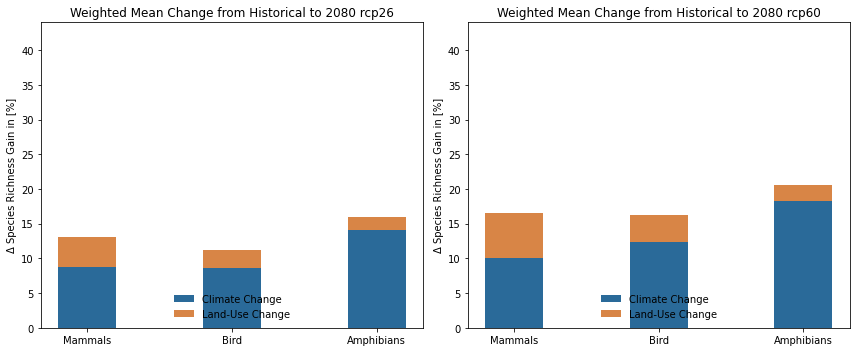

In [ ]:
#weighted mean 

import os
import pickle
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
# Constants


# Specify the output directory
output_dir = "/storage/scratch/users/ch21o450/data/intermediate_results/"

# List of taxa, SDMs, and GCMs
taxas = ["Mammals", "Bird", "Amphibians"]
sdms = ["GAM", "GBM"]
gcms = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

scenarios = ["rcp26", "rcp60"]  # Add rcp26 to the scenarios

time = '65'
time_ind=65
year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

# Load pickled data
mean_newvalue_change = {}
mean_sum_bin_change = {}
mean_land_use_change = {}

weighted_mean_newvalue_change = {}
weighted_mean_sum_bin_change = {}


final_weighted_mean_newvalue_change = {}
final_weighted_mean_sum_bin_change = {}


for scenario in scenarios:
    mean_newvalue_change[scenario] = {}
    mean_sum_bin_change[scenario] = {}
    mean_land_use_change[scenario] = {}
    
    weighted_mean_newvalue_change[scenario] = {}
    weighted_mean_sum_bin_change[scenario] = {}
    
    final_weighted_mean_newvalue_change[scenario] = {}
    final_weighted_mean_sum_bin_change[scenario] = {}
    
    for taxa in taxas: 
        mean_newvalue_change[scenario][taxa]={}
        mean_sum_bin_change[scenario][taxa] = {}
        mean_land_use_change[scenario][taxa] = {}
        
        weighted_mean_newvalue_change[scenario][taxa] = {}
        weighted_mean_sum_bin_change[scenario][taxa] = {}
        
        sdm_data_newvalue = []
        sdm_data_sum_bin = []
        
        for sdm in sdms:
            mean_newvalue_change[scenario][taxa][sdm] = {}
            mean_sum_bin_change[scenario][taxa][sdm] = {}
            mean_land_use_change[scenario][taxa][sdm] = {}
            
            gcm_data_newvalue = []
            gcm_data_sum_bin = []

            for gcm in gcms:
                # Load pickle files
                mean_newvalue_change[scenario][taxa][sdm][gcm] = {}
                mean_sum_bin_change[scenario][taxa][sdm][gcm] = {}
                
                newvalue_hist_sum_path = os.path.join(output_dir, f"newvalue_hist_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                newvalue_future_sum_path = os.path.join(output_dir, f"newvalue_future_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                sum_bin_hist_sum_path = os.path.join(output_dir, f"sum_bin_hist_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                sum_bin_future_sum_path = os.path.join(output_dir, f"sum_bin_future_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")

                with open(newvalue_hist_sum_path, "rb") as f:
                    newvalue_hist_sum_taxa = pickle.load(f)

                with open(newvalue_future_sum_path, "rb") as f:
                    newvalue_future_sum_taxa = pickle.load(f)

                with open(sum_bin_hist_sum_path, "rb") as f:
                    sum_bin_hist_sum_taxa = pickle.load(f)

                with open(sum_bin_future_sum_path, "rb") as f:
                    sum_bin_future_sum_taxa = pickle.load(f)


                # Creating the weights for newvalue_future_sum_taxa
                weights_newvalue = np.cos(np.deg2rad(newvalue_future_sum_taxa.lat))
                weights_newvalue.name = "weights"

                # Displaying the created weights for newvalue_future_sum_taxa
                cell_area_xr = weights_newvalue
                
                # Handle missing values (if necessary)
                da1_filled = newvalue_future_sum_taxa.fillna(0)  # Replace NaNs with 0
                da2_filled = newvalue_hist_sum_taxa.fillna(0)  # Replace NaNs with 0

                                # Calculate the relative difference
                relative_difference = abs(da1_filled - da2_filled) / np.maximum(abs(da1_filled), abs(da2_filled))


                # Handle divisions by zero (if necessary)
                climate_change = relative_difference.fillna(0) * 100 # Replace NaNs from division by zero with 0
                
                
                # Handle missing values (if necessary)
                da1_filled = sum_bin_future_sum_taxa.fillna(0)  # Replace NaNs with 0
                da2_filled = sum_bin_hist_sum_taxa.fillna(0)  # Replace NaNs with 0

                                # Calculate the relative difference
                relative_difference = abs(da1_filled - da2_filled) / np.maximum(abs(da1_filled), abs(da2_filled))


                # Handle divisions by zero (if necessary)
                climate_land_change = relative_difference.fillna(0) * 100  # Replace NaNs from division by zero with 0


# Handle divisions by zero (if necessary)



                land_use_change = climate_land_change - climate_change
                
                

                                #climate_change_loss = climate_change.where(climate_change < 0)
                climate_land_change_gain = climate_land_change.where(climate_land_change>0)
                climate_change_gain = climate_change.where(climate_change > 0)
                
               # climate_change_gain = remove_outliers(climate_change_gain)
               # climate_land_change_gain = remove_outliers(climate_land_change_gain)


                # Store mean changes in dictionaries
                mean_newvalue_change[scenario][taxa][sdm][gcm] = climate_change_gain
                mean_sum_bin_change[scenario][taxa][sdm][gcm] = climate_land_change_gain
                
                gcm_data_newvalue.append(climate_change_gain)
                gcm_data_sum_bin.append(climate_land_change_gain)

            # Convert lists to xarray DataArrays
            gcm_data_newvalue_xr = xr.concat(gcm_data_newvalue, dim='gcm')
            gcm_data_sum_bin_xr = xr.concat(gcm_data_sum_bin, dim='gcm')

            # Calculate weighted mean across GCMs
            weighted_mean_newvalue_change[scenario][taxa][sdm] = gcm_data_newvalue_xr.weighted(cell_area_xr).mean(dim=[ "gcm"])
            weighted_mean_sum_bin_change[scenario][taxa][sdm] = gcm_data_sum_bin_xr.weighted(cell_area_xr).mean(dim=["gcm"])                                                                                                                           

            
            sdm_data_newvalue.append(weighted_mean_newvalue_change[scenario][taxa][sdm])
            sdm_data_sum_bin.append(weighted_mean_sum_bin_change[scenario][taxa][sdm])

        # Convert lists to xarray DataArrays
        sdm_data_newvalue_xr = xr.concat(sdm_data_newvalue, dim='sdm')
        sdm_data_sum_bin_xr = xr.concat(sdm_data_sum_bin, dim='sdm')

        # Calculate the final weighted mean across SDMs
        final_weighted_mean_newvalue_change[scenario][taxa] = sdm_data_newvalue_xr.weighted(cell_area_xr).mean(dim=[ "sdm"])
        final_weighted_mean_sum_bin_change[scenario][taxa] = sdm_data_sum_bin_xr.weighted(cell_area_xr).mean(dim=[ "sdm"])
        
        
        
        
                # Store GCM-specific data in lists


fig, axes = plt.subplots(1, 2, figsize=(12, 5))
color_change = "#2a6a99"
color_land_use_change = "#d88546"

bar_width = 0.4
error_bar_shift = 0.1

x_positions = np.arange(len(taxas))

# Create a variable to store the handles and labels for the legend
handles, labels = [], []

for j, scenario in enumerate(scenarios):
    ax = axes[j]
    scenario_handles, scenario_labels = [], []  # Separate lists for each scenario

    for i, taxa in enumerate(taxas):
        x_shift = x_positions[i]
        

        mean_climate_change = final_weighted_mean_newvalue_change[scenario][taxa].mean(["lat", "lon"]).values
        mean_land_use_change = (final_weighted_mean_sum_bin_change[scenario][taxa]-final_weighted_mean_newvalue_change[scenario][taxa]).mean(["lat", "lon"]).values

        if not i:
            handle_climate_change = ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change, label='Climate Change')
            handle_land_use_change = ax.bar(x_shift, mean_land_use_change, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change, label='Land-Use Change')
  #          handle_error = ax.errorbar(x_shift, mean_climate_change+ mean_land_use_change, yerr=std_dev_climate_change, fmt='none', capsize=3, color='black', label='Climate Change Uncertainty')

            # Extend the scenario-specific lists
  #          scenario_handles.extend([handle_climate_change, handle_land_use_change, handle_error])
 #           scenario_labels.extend(['Climate Change', 'Land-Use Change', 'STD SDMs and GCMs'])

        else:
            ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change)
            ax.bar(x_shift, mean_land_use_change, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change)
       #     ax.errorbar(x_shift, mean_climate_change+ mean_land_use_change, yerr=std_dev_climate_change, fmt='none', capsize=3, color='black')

    # Extend the main lists with scenario-specific entries
    handles.extend(scenario_handles)
    labels.extend(scenario_labels)
#for ax in axes:

    # Set plot details
    ax.set_ylim(top=44, bottom=0)
    ax.set_xticks(x_positions)
    ax.set_xticklabels(taxas)
    ax.set_ylabel('\u0394 Species Richness Gain in [%]')
    ax.legend(handles=scenario_handles, labels=scenario_labels, frameon=False, loc='lower center')
    ax.set_title(f'Weighted Mean Change from Historical to {year_indices[time_ind]} {scenario}')

# Set the final legend outside the loop
#fig.legend(handles=handles, labels=labels, frameon=False, loc='lower center')

plt.tight_layout()
plt.show()


In [53]:
mean_land_use_change

array(2.61648035)

In [34]:
mean_land_use_change

array(2.24446533)

In [25]:
np.mean([np.nanmean(mean_newvalue_change[scenario][taxa][sdm][gcm].values) for sdm in sdms])

16.37612203668265

In [21]:
air_weighted = gcm_data_newvalue_xr.weighted(cell_area_xr)
weighted_mean = air_weighted.mean(("lon", "lat"))
weighted_mean.mean()




<xarray.DataArray 'newvalue' ()>
array(11.05936322)

In [26]:
air_weighted = sdm_data_newvalue_xr.weighted(cell_area_xr)
weighted_mean = air_weighted.mean(("lon", "lat"))
weighted_mean.mean()

<xarray.DataArray 'newvalue' ()>
array(16.73687953)

In [57]:
cell_areas =cell_area_xr

In [61]:
cell_areas

<xarray.DataArray 'weights' (lat: 360)>
array([0.00436331, 0.0130896 , 0.02181489, 0.03053851, 0.03925982,
       0.04797813, 0.05669279, 0.06540313, 0.07410849, 0.08280821,
       0.09150162, 0.10018806, 0.10886687, 0.1175374 , 0.12619897,
       0.13485093, 0.14349262, 0.15212339, 0.16074257, 0.1693495 ,
       0.17794355, 0.18652404, 0.19509032, 0.20364175, 0.21217767,
       0.22069744, 0.22920039, 0.23768589, 0.24615329, 0.25460195,
       0.26303121, 0.27144045, 0.27982901, 0.28819627, 0.29654157,
       0.3048643 , 0.31316381, 0.32143947, 0.32969065, 0.33791672,
       0.34611706, 0.35429104, 0.36243804, 0.37055744, 0.37864862,
       0.38671096, 0.39474386, 0.40274669, 0.41071885, 0.41865974,
       0.42656874, 0.43444526, 0.44228869, 0.45009844, 0.45787392,
       0.46561452, 0.47331967, 0.48098877, 0.48862124, 0.4962165 ,
       0.50377398, 0.51129309, 0.51877326, 0.52621392, 0.53361452,
       0.54097447, 0.54829323, 0.55557023, 0.56280493, 0.56999676,
       0.57714519, 0.58424967, 0.59130965, 0.5983246 , 0.60529399,
       0.61221728, 0.61909395, 0.62592347, 0.63270533, 0.639439  ,
       0.64612398, 0.65275975, 0.65934582, 0.66588167, 0.67236681,
       0.67880075, 0.68518299, 0.69151306, 0.69779046, 0.70401472,
       0.71018538, 0.71630194, 0.72236396, 0.72837097, 0.73432251,
       0.74021813, 0.74605738, 0.75183981, 0.75756498, 0.76323247,
...
       0.76323247, 0.75756498, 0.75183981, 0.74605738, 0.74021813,
       0.73432251, 0.72837097, 0.72236396, 0.71630194, 0.71018538,
       0.70401472, 0.69779046, 0.69151306, 0.68518299, 0.67880075,
       0.67236681, 0.66588167, 0.65934582, 0.65275975, 0.64612398,
       0.639439  , 0.63270533, 0.62592347, 0.61909395, 0.61221728,
       0.60529399, 0.5983246 , 0.59130965, 0.58424967, 0.57714519,
       0.56999676, 0.56280493, 0.55557023, 0.54829323, 0.54097447,
       0.53361452, 0.52621392, 0.51877326, 0.51129309, 0.50377398,
       0.4962165 , 0.48862124, 0.48098877, 0.47331967, 0.46561452,
       0.45787392, 0.45009844, 0.44228869, 0.43444526, 0.42656874,
       0.41865974, 0.41071885, 0.40274669, 0.39474386, 0.38671096,
       0.37864862, 0.37055744, 0.36243804, 0.35429104, 0.34611706,
       0.33791672, 0.32969065, 0.32143947, 0.31316381, 0.3048643 ,
       0.29654157, 0.28819627, 0.27982901, 0.27144045, 0.26303121,
       0.25460195, 0.24615329, 0.23768589, 0.22920039, 0.22069744,
       0.21217767, 0.20364175, 0.19509032, 0.18652404, 0.17794355,
       0.1693495 , 0.16074257, 0.15212339, 0.14349262, 0.13485093,
       0.12619897, 0.1175374 , 0.10886687, 0.10018806, 0.09150162,
       0.08280821, 0.07410849, 0.06540313, 0.05669279, 0.04797813,
       0.03925982, 0.03053851, 0.02181489, 0.0130896 , 0.00436331])
Coordinates:
  * lat      (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75

In [66]:
import pandas as pd
cell_areas_df = pd.DataFrame(cell_areas)


In [67]:
cell_areas_df

,0
0,0.004363
1,0.013090
2,0.021815
3,0.030539
4,0.039260
...,...
355,0.039260
356,0.030539
357,0.021815
358,0.013090


In [71]:
lat_cell_areas = cell_areas_df.values
lat_cell_numbers = cell_areas_df.iloc[:, 0].values


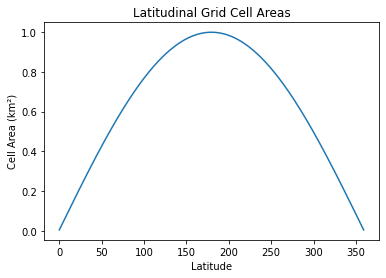

AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [72]:
import matplotlib.pyplot as plt

# Plot the latitudinal grid cell areas
plt.plot(lat_cell_areas)
plt.xlabel('Latitude')
plt.ylabel('Cell Area (km²)')
plt.title('Latitudinal Grid Cell Areas')
plt.show()

# Plot the barplots with the number of grid cells
plt.bar(lat_cell_areas.index, lat_cell_numbers)
plt.xlabel('Latitude')
plt.ylabel('Number of Grid Cells')
plt.title('Number of Grid Cells per Latitude')
plt.show()


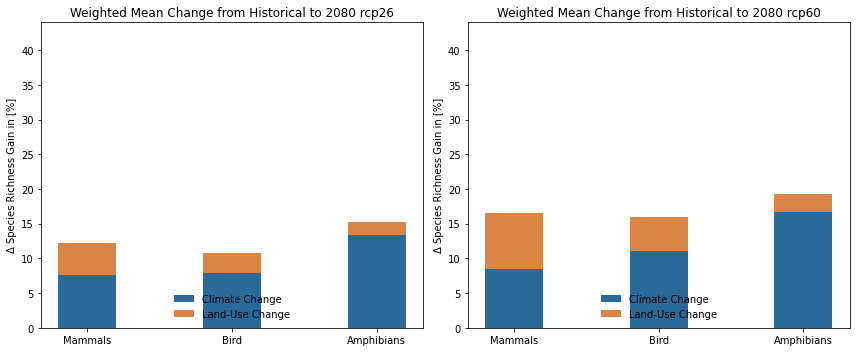

In [45]:
#weighted mean 

import os
import pickle
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
# Constants


# Specify the output directory
output_dir = "/storage/scratch/users/ch21o450/data/intermediate_results/"

# List of taxa, SDMs, and GCMs
taxas = ["Mammals", "Bird", "Amphibians"]
sdms = ["GAM", "GBM"]
gcms = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

scenarios = ["rcp26", "rcp60"]  # Add rcp26 to the scenarios

time = '65'
time_ind=65
year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

# Load pickled data
mean_newvalue_change = {}
mean_sum_bin_change = {}
mean_land_use_change = {}

weighted_mean_newvalue_change = {}
weighted_mean_sum_bin_change = {}


final_weighted_mean_newvalue_change = {}
final_weighted_mean_sum_bin_change = {}


for scenario in scenarios:
    mean_newvalue_change[scenario] = {}
    mean_sum_bin_change[scenario] = {}
    mean_land_use_change[scenario] = {}
    
    weighted_mean_newvalue_change[scenario] = {}
    weighted_mean_sum_bin_change[scenario] = {}
    
    final_weighted_mean_newvalue_change[scenario] = {}
    final_weighted_mean_sum_bin_change[scenario] = {}
    
    for taxa in taxas: 
        mean_newvalue_change[scenario][taxa]={}
        mean_sum_bin_change[scenario][taxa] = {}
        mean_land_use_change[scenario][taxa] = {}
        
        weighted_mean_newvalue_change[scenario][taxa] = {}
        weighted_mean_sum_bin_change[scenario][taxa] = {}
        
        sdm_data_newvalue = []
        sdm_data_sum_bin = []
        
        for sdm in sdms:
            mean_newvalue_change[scenario][taxa][sdm] = {}
            mean_sum_bin_change[scenario][taxa][sdm] = {}
            mean_land_use_change[scenario][taxa][sdm] = {}
            
            gcm_data_newvalue = []
            gcm_data_sum_bin = []

            for gcm in gcms:
                # Load pickle files
                mean_newvalue_change[scenario][taxa][sdm][gcm] = {}
                mean_sum_bin_change[scenario][taxa][sdm][gcm] = {}
                
                newvalue_hist_sum_path = os.path.join(output_dir, f"newvalue_hist_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                newvalue_future_sum_path = os.path.join(output_dir, f"newvalue_future_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                sum_bin_hist_sum_path = os.path.join(output_dir, f"sum_bin_hist_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                sum_bin_future_sum_path = os.path.join(output_dir, f"sum_bin_future_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")

                with open(newvalue_hist_sum_path, "rb") as f:
                    newvalue_hist_sum_taxa = pickle.load(f)

                with open(newvalue_future_sum_path, "rb") as f:
                    newvalue_future_sum_taxa = pickle.load(f)

                with open(sum_bin_hist_sum_path, "rb") as f:
                    sum_bin_hist_sum_taxa = pickle.load(f)

                with open(sum_bin_future_sum_path, "rb") as f:
                    sum_bin_future_sum_taxa = pickle.load(f)


                # Creating the weights for newvalue_future_sum_taxa
                weights_newvalue = np.cos(np.deg2rad(newvalue_future_sum_taxa.lat))
                weights_newvalue.name = "weights"

                # Displaying the created weights for newvalue_future_sum_taxa
                cell_area_xr = weights_newvalue
                
                # Handle missing values (if necessary)
                da1_filled = newvalue_future_sum_taxa.fillna(0)  # Replace NaNs with 0
                da2_filled = newvalue_hist_sum_taxa.fillna(0)  # Replace NaNs with 0

                                # Calculate the relative difference
                relative_difference = abs(da1_filled - da2_filled) / np.maximum(abs(da1_filled), abs(da2_filled))


                # Handle divisions by zero (if necessary)
                climate_change = relative_difference.fillna(0) * 100 # Replace NaNs from division by zero with 0
                
                
                # Handle missing values (if necessary)
                da1_filled = sum_bin_future_sum_taxa.fillna(0)  # Replace NaNs with 0
                da2_filled = sum_bin_hist_sum_taxa.fillna(0)  # Replace NaNs with 0

                                # Calculate the relative difference
                relative_difference = abs(da1_filled - da2_filled) / np.maximum(abs(da1_filled), abs(da2_filled))


                # Handle divisions by zero (if necessary)
                climate_land_change = relative_difference.fillna(0) * 100  # Replace NaNs from division by zero with 0


# Handle divisions by zero (if necessary)



                land_use_change = climate_land_change - climate_change
                
                

                                #climate_change_loss = climate_change.where(climate_change < 0)
                climate_land_change_gain = climate_land_change.where(climate_land_change>0)
                climate_change_gain = climate_change.where(climate_change > 0)
                
               # climate_change_gain = remove_outliers(climate_change_gain)
               # climate_land_change_gain = remove_outliers(climate_land_change_gain)


                # Store mean changes in dictionaries
                mean_newvalue_change[scenario][taxa][sdm][gcm] = climate_change_gain
                mean_sum_bin_change[scenario][taxa][sdm][gcm] = climate_land_change_gain
                
                weights_newvalue = np.cos(np.deg2rad(newvalue_future_sum_taxa.lat))
                weights_newvalue.name = "weights"
                cell_area_xr = weights_newvalue

                # Calculate weighted mean for each GCM
                air_weighted_gcm = climate_change_gain.weighted(cell_area_xr)
                weighted_mean_gcm = air_weighted_gcm.mean(("lon", "lat"))
                gcm_data_newvalue.append(weighted_mean_gcm)

                # Repeat for sum_bin data
                air_weighted_gcm = climate_land_change_gain.weighted(cell_area_xr)
                weighted_mean_gcm = air_weighted_gcm.mean(("lon", "lat"))
                gcm_data_sum_bin.append(weighted_mean_gcm)

            # Calculate weighted mean across GCMs
            gcm_data_newvalue_xr = xr.concat(gcm_data_newvalue, dim='gcm')
            weighted_mean_newvalue_change[scenario][taxa][sdm] = gcm_data_newvalue_xr.mean(dim="gcm")

            gcm_data_sum_bin_xr = xr.concat(gcm_data_sum_bin, dim='gcm')
            weighted_mean_sum_bin_change[scenario][taxa][sdm] = gcm_data_sum_bin_xr.mean(dim="gcm")

            sdm_data_newvalue.append(weighted_mean_newvalue_change[scenario][taxa][sdm])
            sdm_data_sum_bin.append(weighted_mean_sum_bin_change[scenario][taxa][sdm])

        # Calculate weighted mean across SDMs
        sdm_data_newvalue_xr = xr.concat(sdm_data_newvalue, dim='sdm')
        final_weighted_mean_newvalue_change[scenario][taxa] = sdm_data_newvalue_xr.mean(dim="sdm")

        sdm_data_sum_bin_xr = xr.concat(sdm_data_sum_bin, dim='sdm')
        final_weighted_mean_sum_bin_change[scenario][taxa] = sdm_data_sum_bin_xr.mean(dim="sdm")

        
                # Store GCM-specific data in lists


fig, axes = plt.subplots(1, 2, figsize=(12, 5))
color_change = "#2a6a99"
color_land_use_change = "#d88546"

bar_width = 0.4
error_bar_shift = 0.1

x_positions = np.arange(len(taxas))

# Create a variable to store the handles and labels for the legend
handles, labels = [], []

for j, scenario in enumerate(scenarios):
    ax = axes[j]
    scenario_handles, scenario_labels = [], []  # Separate lists for each scenario

    for i, taxa in enumerate(taxas):
        x_shift = x_positions[i]
        

        mean_climate_change = final_weighted_mean_newvalue_change[scenario][taxa].mean().values
        mean_land_use_change = (final_weighted_mean_sum_bin_change[scenario][taxa]-final_weighted_mean_newvalue_change[scenario][taxa]).mean().values

        if not i:
            handle_climate_change = ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change, label='Climate Change')
            handle_land_use_change = ax.bar(x_shift, mean_land_use_change, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change, label='Land-Use Change')
  #          handle_error = ax.errorbar(x_shift, mean_climate_change+ mean_land_use_change, yerr=std_dev_climate_change, fmt='none', capsize=3, color='black', label='Climate Change Uncertainty')

            # Extend the scenario-specific lists
  #          scenario_handles.extend([handle_climate_change, handle_land_use_change, handle_error])
 #           scenario_labels.extend(['Climate Change', 'Land-Use Change', 'STD SDMs and GCMs'])

        else:
            ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change)
            ax.bar(x_shift, mean_land_use_change, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change)
       #     ax.errorbar(x_shift, mean_climate_change+ mean_land_use_change, yerr=std_dev_climate_change, fmt='none', capsize=3, color='black')

    # Extend the main lists with scenario-specific entries
    handles.extend(scenario_handles)
    labels.extend(scenario_labels)
#for ax in axes:

    # Set plot details
    ax.set_ylim(top=44, bottom=0)
    ax.set_xticks(x_positions)
    ax.set_xticklabels(taxas)
    ax.set_ylabel('\u0394 Species Richness Gain in [%]')
    ax.legend(handles=scenario_handles, labels=scenario_labels, frameon=False, loc='lower center')
    ax.set_title(f'Weighted Mean Change from Historical to {year_indices[time_ind]} {scenario}')

# Set the final legend outside the loop
#fig.legend(handles=handles, labels=labels, frameon=False, loc='lower center')

plt.tight_layout()
plt.show()


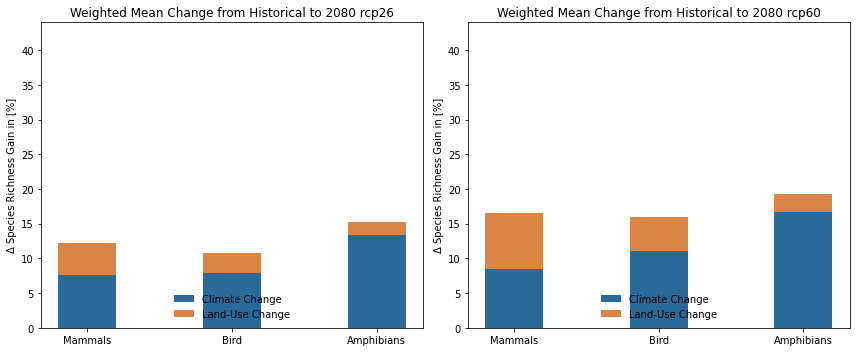

In [46]:
#weighted mean but turn around where we do it 

import os
import pickle
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
# Constants


# Specify the output directory
output_dir = "/storage/scratch/users/ch21o450/data/intermediate_results/"

# List of taxa, SDMs, and GCMs
taxas = ["Mammals", "Bird", "Amphibians"]
sdms = ["GAM", "GBM"]
gcms = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

scenarios = ["rcp26", "rcp60"]  # Add rcp26 to the scenarios

time = '65'
time_ind=65
year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

# Load pickled data
mean_newvalue_change = {}
mean_sum_bin_change = {}
mean_land_use_change = {}

weighted_mean_newvalue_change = {}
weighted_mean_sum_bin_change = {}


final_weighted_mean_newvalue_change = {}
final_weighted_mean_sum_bin_change = {}


for scenario in scenarios:
    mean_newvalue_change[scenario] = {}
    mean_sum_bin_change[scenario] = {}
    mean_land_use_change[scenario] = {}
    
    weighted_mean_newvalue_change[scenario] = {}
    weighted_mean_sum_bin_change[scenario] = {}
    
    final_weighted_mean_newvalue_change[scenario] = {}
    final_weighted_mean_sum_bin_change[scenario] = {}
    
    for taxa in taxas: 
        mean_newvalue_change[scenario][taxa]={}
        mean_sum_bin_change[scenario][taxa] = {}
        mean_land_use_change[scenario][taxa] = {}
        
        weighted_mean_newvalue_change[scenario][taxa] = {}
        weighted_mean_sum_bin_change[scenario][taxa] = {}
        
        sdm_data_newvalue = []
        sdm_data_sum_bin = []
        
        for sdm in sdms:
            mean_newvalue_change[scenario][taxa][sdm] = {}
            mean_sum_bin_change[scenario][taxa][sdm] = {}
            mean_land_use_change[scenario][taxa][sdm] = {}
            
            gcm_data_newvalue = []
            gcm_data_sum_bin = []

            for gcm in gcms:
                # Load pickle files
                mean_newvalue_change[scenario][taxa][sdm][gcm] = {}
                mean_sum_bin_change[scenario][taxa][sdm][gcm] = {}
                
                newvalue_hist_sum_path = os.path.join(output_dir, f"newvalue_hist_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                newvalue_future_sum_path = os.path.join(output_dir, f"newvalue_future_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                sum_bin_hist_sum_path = os.path.join(output_dir, f"sum_bin_hist_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")
                sum_bin_future_sum_path = os.path.join(output_dir, f"sum_bin_future_sum_{sdm}_{gcm}_{taxa}_['{scenario}']_['{time}'].pkl")

                with open(newvalue_hist_sum_path, "rb") as f:
                    newvalue_hist_sum_taxa = pickle.load(f)

                with open(newvalue_future_sum_path, "rb") as f:
                    newvalue_future_sum_taxa = pickle.load(f)

                with open(sum_bin_hist_sum_path, "rb") as f:
                    sum_bin_hist_sum_taxa = pickle.load(f)

                with open(sum_bin_future_sum_path, "rb") as f:
                    sum_bin_future_sum_taxa = pickle.load(f)


                # Creating the weights for newvalue_future_sum_taxa
                weights_newvalue = np.cos(np.deg2rad(newvalue_future_sum_taxa.lat))
                weights_newvalue.name = "weights"

                # Displaying the created weights for newvalue_future_sum_taxa
                cell_area_xr = weights_newvalue
                
                # Handle missing values (if necessary)
                da1_filled = newvalue_future_sum_taxa.fillna(0)  # Replace NaNs with 0
                da2_filled = newvalue_hist_sum_taxa.fillna(0)  # Replace NaNs with 0

                                # Calculate the relative difference
                relative_difference = abs(da1_filled - da2_filled) / np.maximum(abs(da1_filled), abs(da2_filled))


                # Handle divisions by zero (if necessary)
                climate_change = relative_difference.fillna(0) * 100 # Replace NaNs from division by zero with 0
                
                
                # Handle missing values (if necessary)
                da1_filled = sum_bin_future_sum_taxa.fillna(0)  # Replace NaNs with 0
                da2_filled = sum_bin_hist_sum_taxa.fillna(0)  # Replace NaNs with 0

                                # Calculate the relative difference
                relative_difference = abs(da1_filled - da2_filled) / np.maximum(abs(da1_filled), abs(da2_filled))


                # Handle divisions by zero (if necessary)
                climate_land_change = relative_difference.fillna(0) * 100  # Replace NaNs from division by zero with 0


# Handle divisions by zero (if necessary)



                land_use_change = climate_land_change - climate_change
                
                

                                #climate_change_loss = climate_change.where(climate_change < 0)
                climate_land_change_gain = climate_land_change.where(climate_land_change>0)
                climate_change_gain = climate_change.where(climate_change > 0)
                
               # climate_change_gain = remove_outliers(climate_change_gain)
               # climate_land_change_gain = remove_outliers(climate_land_change_gain)


                # Store mean changes in dictionaries
                mean_newvalue_change[scenario][taxa][sdm][gcm] = climate_change_gain
                mean_sum_bin_change[scenario][taxa][sdm][gcm] = climate_land_change_gain
                
                weights_newvalue = np.cos(np.deg2rad(newvalue_future_sum_taxa.lat))
                weights_newvalue.name = "weights"
                cell_area_xr = weights_newvalue

                # Calculate weighted mean for each GCM
                air_weighted_gcm = climate_change_gain.weighted(cell_area_xr)
                weighted_mean_gcm = air_weighted_gcm.mean(("lon", "lat"))
                gcm_data_newvalue.append(weighted_mean_gcm)

                # Repeat for sum_bin data
                air_weighted_gcm = climate_land_change_gain.weighted(cell_area_xr)
                weighted_mean_gcm = air_weighted_gcm.mean(("lon", "lat"))
                gcm_data_sum_bin.append(weighted_mean_gcm)

            # Calculate weighted mean across GCMs
            gcm_data_newvalue_xr = xr.concat(gcm_data_newvalue, dim='gcm')
            weighted_mean_newvalue_change[scenario][taxa][sdm] = gcm_data_newvalue_xr.mean(dim="gcm")

            gcm_data_sum_bin_xr = xr.concat(gcm_data_sum_bin, dim='gcm')
            weighted_mean_sum_bin_change[scenario][taxa][sdm] = gcm_data_sum_bin_xr.mean(dim="gcm")

            sdm_data_newvalue.append(weighted_mean_newvalue_change[scenario][taxa][sdm])
            sdm_data_sum_bin.append(weighted_mean_sum_bin_change[scenario][taxa][sdm])

        # Calculate weighted mean across SDMs
        sdm_data_newvalue_xr = xr.concat(sdm_data_newvalue, dim='sdm')
        
        sdm_data_sum_bin_xr = xr.concat(sdm_data_sum_bin, dim='sdm')


        final_weighted_mean_newvalue_change[scenario][taxa] = sdm_data_newvalue_xr.weighted(cell_area_xr).mean(dim=["sdm"])
        final_weighted_mean_sum_bin_change[scenario][taxa] = sdm_data_sum_bin_xr.weighted(cell_area_xr).mean(dim=["sdm"])

                # Store GCM-specific data in lists


fig, axes = plt.subplots(1, 2, figsize=(12, 5))
color_change = "#2a6a99"
color_land_use_change = "#d88546"

bar_width = 0.4
error_bar_shift = 0.1

x_positions = np.arange(len(taxas))

# Create a variable to store the handles and labels for the legend
handles, labels = [], []

for j, scenario in enumerate(scenarios):
    ax = axes[j]
    scenario_handles, scenario_labels = [], []  # Separate lists for each scenario

    for i, taxa in enumerate(taxas):
        x_shift = x_positions[i]
        

        mean_climate_change = final_weighted_mean_newvalue_change[scenario][taxa].mean().values
        mean_land_use_change = (final_weighted_mean_sum_bin_change[scenario][taxa]-final_weighted_mean_newvalue_change[scenario][taxa]).mean().values

        if not i:
            handle_climate_change = ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change, label='Climate Change')
            handle_land_use_change = ax.bar(x_shift, mean_land_use_change, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change, label='Land-Use Change')
  #          handle_error = ax.errorbar(x_shift, mean_climate_change+ mean_land_use_change, yerr=std_dev_climate_change, fmt='none', capsize=3, color='black', label='Climate Change Uncertainty')

            # Extend the scenario-specific lists
  #          scenario_handles.extend([handle_climate_change, handle_land_use_change, handle_error])
 #           scenario_labels.extend(['Climate Change', 'Land-Use Change', 'STD SDMs and GCMs'])

        else:
            ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change)
            ax.bar(x_shift, mean_land_use_change, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change)
       #     ax.errorbar(x_shift, mean_climate_change+ mean_land_use_change, yerr=std_dev_climate_change, fmt='none', capsize=3, color='black')

    # Extend the main lists with scenario-specific entries
    handles.extend(scenario_handles)
    labels.extend(scenario_labels)
#for ax in axes:

    # Set plot details
    ax.set_ylim(top=44, bottom=0)
    ax.set_xticks(x_positions)
    ax.set_xticklabels(taxas)
    ax.set_ylabel('\u0394 Species Richness Gain in [%]')
    ax.legend(handles=scenario_handles, labels=scenario_labels, frameon=False, loc='lower center')
    ax.set_title(f'Weighted Mean Change from Historical to {year_indices[time_ind]} {scenario}')

# Set the final legend outside the loop
#fig.legend(handles=handles, labels=labels, frameon=False, loc='lower center')

plt.tight_layout()
plt.show()


In [51]:
weighted_mean_gcm

<xarray.DataArray 'sum_bin' ()>
array(13.95721507)

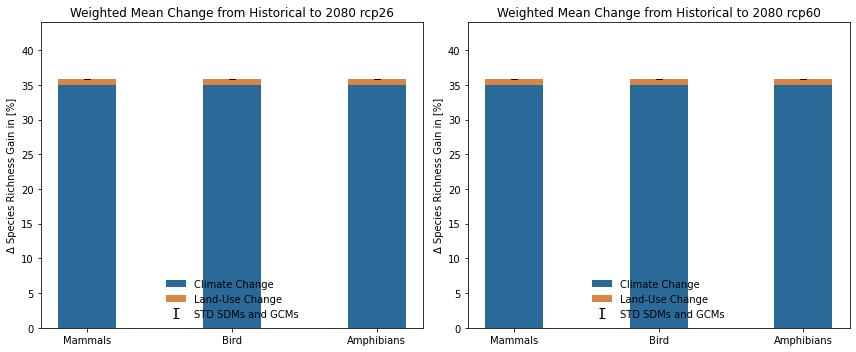

In [33]:
mean_land_use_change
def calculate_cell_area_as_xarray(lat, earth_radius=6371.0):
    # Calculate differences in latitudes
    lat_diff = np.abs(np.diff(lat)).mean()
    lat_radians = np.radians(lat)
    
    # Calculate cell area
    area = (np.pi / 180) * earth_radius**2 * np.abs(
        np.sin(np.radians(lat_radians + lat_diff / 2)) -
        np.sin(np.radians(lat_radians - lat_diff / 2))
    )
    
    # Create an xarray DataArray
    cell_area_xr = xr.DataArray(area, coords=[lat], dims=["lat"])
    
    return cell_area_xr


fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ... (rest of your setup)

for j, scenario in enumerate(scenarios):
    ax = axes[j]
    scenario_handles, scenario_labels = [], []  # Separate lists for each scenario

    for i, taxa in enumerate(taxas):
        x_shift = x_positions[i]
        

        # Calculate the mean of the weighted means across all SDMs and GCMs
        mean_climate_change = np.nanmean([value.values for value in weighted_mean_climate_change])
        mean_land_use_change = np.nanmean([value.values for value in weighted_mean_land_use_change])



        #cell_area_xr = calculate_cell_area_as_xarray(newvalue_future_sum_taxa['lat'])   
                
        #mean_climate_change = np.nanmean([mean_newvalue_change[scenario][sdm][gcm][taxa].weighted(cell_area_xr).mean(dim=["lat", "lon"]) for sdm in sdms for gcm in gcms])
        #mean_land_use_change = np.nanmean([mean_sum_bin_change[scenario][sdm][gcm][taxa].weighted(cell_area_xr).mean(dim=["lat", "lon"]) - mean_newvalue_change[scenario][sdm][gcm][taxa].weighted(cell_area_xr).mean(dim=["lat", "lon"]) for sdm in sdms for gcm in gcms])


        if not i:
            handle_climate_change = ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change, label='Climate Change')
            handle_land_use_change = ax.bar(x_shift, mean_land_use_change, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change, label='Land-Use Change')
            handle_error = ax.errorbar(x_shift, mean_climate_change+ mean_land_use_change, yerr=std_dev_climate_change, fmt='none', capsize=3, color='black', label='Climate Change Uncertainty')

            # Extend the scenario-specific lists
            scenario_handles.extend([handle_climate_change, handle_land_use_change, handle_error])
            scenario_labels.extend(['Climate Change', 'Land-Use Change', 'STD SDMs and GCMs'])

        else:
            ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change)
            ax.bar(x_shift, mean_land_use_change, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change)
            ax.errorbar(x_shift, mean_climate_change+ mean_land_use_change, yerr=std_dev_climate_change, fmt='none', capsize=3, color='black')

    # Extend the main lists with scenario-specific entries
    handles.extend(scenario_handles)
    labels.extend(scenario_labels)
#for ax in axes:

    # Set plot details
    ax.set_ylim(top=44, bottom=0)
    ax.set_xticks(x_positions)
    ax.set_xticklabels(taxas)
    ax.set_ylabel('\u0394 Species Richness Gain in [%]')
    ax.legend(handles=scenario_handles, labels=scenario_labels, frameon=False, loc='lower center')
    ax.set_title(f'Weighted Mean Change from Historical to {year_indices[time_ind]} {scenario}')

# Set the final legend outside the loop
#fig.legend(handles=handles, labels=labels, frameon=False, loc='lower center')

plt.tight_layout()
plt.show()


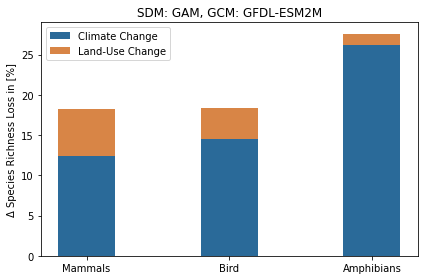

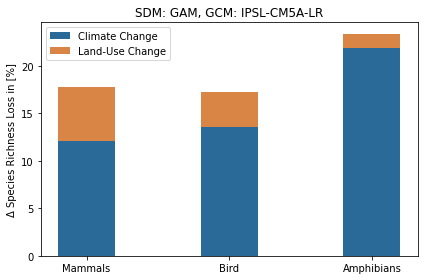

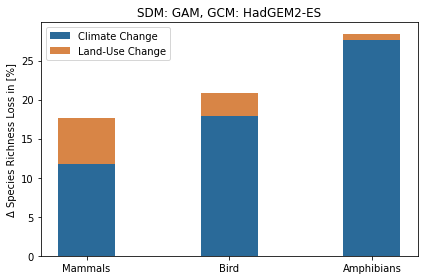

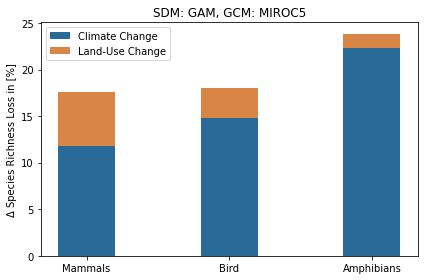

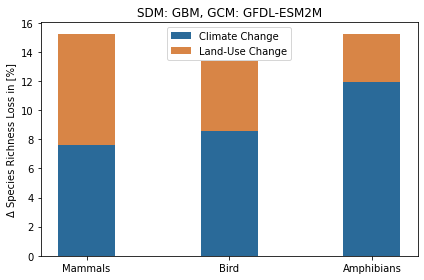

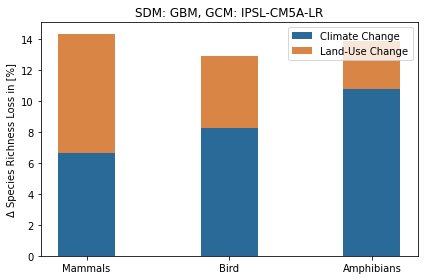

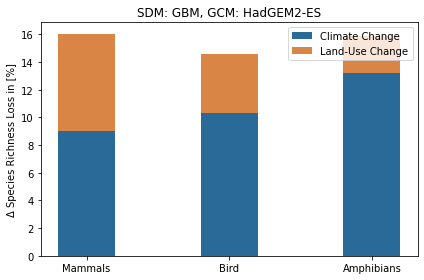

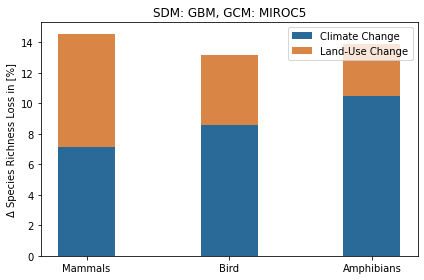

In [69]:

# Create separate plots for each combination of SDM and GCM
for sdm in sdms:
    for gcm in gcms:
        # Set up the bar plot
        fig, ax = plt.subplots()

        color_change = "#2a6a99"
        color_land_use_change = "#d88546"

        bar_width = 0.4
        error_bar_shift = 0.1

        x_positions = np.arange(len(taxas))

        # Create a variable to store the handles and labels for the legend
        handles, labels = [], []

        for i, taxa in enumerate(taxas):
            x_shift = x_positions[i]

            # Calculate the mean values for the specific combination of SDM and GCM
            mean_climate_change = np.mean(mean_newvalue_change[scenario][sdm][gcm][taxa])
            mean_land_use_change2 = np.mean(mean_sum_bin_change[scenario][sdm][gcm][taxa] - mean_newvalue_change[scenario][sdm][gcm][taxa])

            # Calculate standard deviation or confidence interval for climate_change


            if not i:
                handle_climate_change = ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change, label='Climate Change')
                handle_land_use_change = ax.bar(x_shift, mean_land_use_change2, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change, label='Land-Use Change')

            else:
                ax.bar(x_shift, mean_climate_change, capsize=5, width=bar_width, color=color_change)
                ax.bar(x_shift, mean_land_use_change2, capsize=5, width=bar_width, color=color_land_use_change, bottom=mean_climate_change)


        # Combine handles and labels for legend
        handles.extend([handle_climate_change, handle_land_use_change])
        labels.extend(['Climate Change', 'Land-Use Change', 'Uncertainty'])

        # Set plot details
        ax.set_xticks(x_positions)
        ax.set_xticklabels(taxas)
        ax.set_ylabel('\u0394 Species Richness Loss in [%]')
        ax.legend(handles=handles, labels=labels)

        # Set plot title with the combination of SDM and GCM
        ax.set_title(f"SDM: {sdm}, GCM: {gcm}")

        plt.tight_layout()
        plt.show()
